In [49]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Load data

In [50]:
X = pd.read_pickle('X.pkl')
y = pd.read_pickle('y.pkl')

In [51]:
X

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking
0,1.192945,0,0.622916,0,-1.530560,1,1.681648e-02,0.979921,-1.504036,1,0
1,-0.491279,0,2.930118,0,-0.007077,0,7.535660e-09,-0.228312,-0.141976,1,0
2,0.350833,0,-0.598927,0,-1.530560,0,-1.038073e+00,0.140991,-1.731046,1,1
3,-0.912335,1,-0.840088,0,-1.530560,0,-5.464741e-01,0.979921,0.085034,1,0
4,0.350833,1,-0.518250,1,-1.530560,0,6.517986e-01,1.756749,-4.682176,0,0
...,...,...,...,...,...,...,...,...,...,...,...
294,0.098199,0,-1.364532,1,-0.007077,1,-1.109765e+00,-0.228312,1.447094,1,1
295,-0.491279,0,1.632981,0,-0.007077,0,6.802472e-02,-0.035958,0.539054,0,0
296,-1.333392,0,1.742777,1,1.854958,0,4.902082e+00,-0.932311,0.312044,0,0
297,-1.333392,0,1.882980,0,-0.007077,0,-1.263389e+00,0.304820,0.766064,1,1


In [52]:
y

,death_event
0,1
1,1
2,1
3,1
4,1
...,...
294,0
295,0
296,0
297,0


### **Set up Logistic Regression model**
We want to set up our logistic regression by using a neural network. We will use one Linear Layer and the sigmoid function to transform our data in a range between 0 and 1.

In [53]:
class LogisticRegression(nn.Module): 
    def __init__(self, input_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_features = input_dimensions, out_features = 1)

    def forward(self,x): # Define forard function which applies sigmoid function to our output 
        return torch.sigmoid(self.linear(x))

So far, we will use the *binary cross-entropy-loss* (**BCELoss**). Later on, one can try different other loss functions.  
For a standard Logistic Regression without any regularization, we can use *Gradient Descent* as an optimization tool.

In [54]:
X_tensor = torch.tensor(X.values, dtype=torch.float32)
Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

## **Test different learning rates**

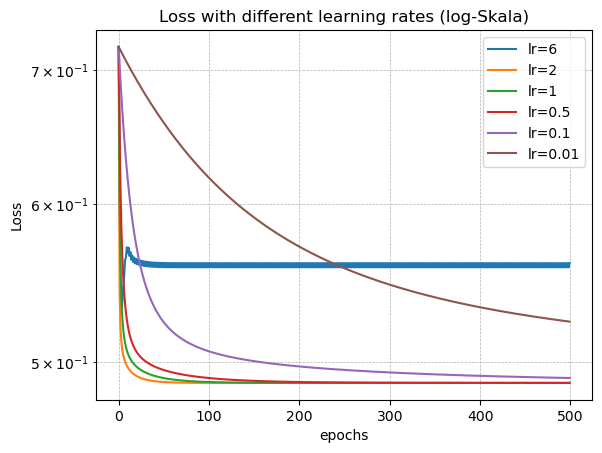

In [55]:
lr = [6, 2, 1, 0.5, 0.1, 0.01]
losses = []

for learning_rate in lr:
    torch.manual_seed(41)
    LR_model = LogisticRegression(input_dimensions=X.shape[1])

    loss_fun = nn.BCELoss() 
    optimizer = optim.SGD(LR_model.parameters(), lr=learning_rate)

    X_tensor = torch.tensor(X.values, dtype=torch.float32)
    Y_tensor = torch.tensor(y.values, dtype=torch.float32).view(-1, 1)

    epochs = 500

    # We wish to save the trajectory of weight, bias and loss
    hist_W = []
    hist_b = []
    hist_loss = []

    #Trainigsloop bleibt auch bei mehrschichtigen Netzen gleich
    for epoch in range(epochs):
        pred = LR_model(X_tensor)                       # Forward pass
        loss = loss_fun(pred, Y_tensor)                 # Compute loss

        optimizer.zero_grad()   # Gradienten auf Null setzen
        loss.backward()         # Berechne den Gradienten
        optimizer.step()        # Optimierungsschritt nach Gradient Descent 

        hist_loss.append(loss.item())
    
    losses.append(hist_loss)

for hist_loss in losses:
    plt.plot(hist_loss)

plt.xlabel("epochs")
plt.ylabel("Loss")
plt.yscale("log")  # <-- log-Skalierung der y-Achse
plt.legend([f"lr={l}" for l in lr])
plt.title("Loss with different learning rates (log-Skala)")
plt.grid(True, which="both", linestyle="--", linewidth=0.5)

## **Introduce Regularization**
First, we build up a complete model, including a fit() and pred() function.

In [56]:
class LR_complete(nn.Module): 
    def __init__(self, input_dimensions):
        super().__init__()
        self.linear = nn.Linear(in_features = input_dimensions, out_features = 1)

    def forward(self,x): # Define forard function which applies sigmoid function to our output 
        return torch.sigmoid(self.linear(x))

    def fit(self, X_train, y_train, epochs=500, learning_rate = 0.005, regularization = None, alpha = 1):
        X_train_tensor = torch.tensor(X_train.values, dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)

        loss_fun = nn.BCELoss() 
        if regularization == "l1":
            optimizer = optim.Adam(self.parameters(), lr=learning_rate)            
        else:
            optimizer = optim.SGD(self.parameters(), lr=learning_rate)
        
        for epoch in range(epochs):
            pred = self.forward(X_train_tensor)
            base_loss = loss_fun(pred, y_train_tensor)

            if regularization == 'l1':
                l1_penalty = torch.sum(torch.abs(self.linear.weight))
                reg_term = alpha * l1_penalty

            elif regularization == 'l2':
                l2_penalty = torch.sum(self.linear.weight ** 2)
                reg_term = alpha * l2_penalty
            
            else:
                reg_term = torch.tensor(0.0)
            
            loss = base_loss + reg_term

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            #if epoch % 100 == 0:
                #print("Epoch ", epoch, " : ",base_loss)

        self.final_weights = self.linear.weight.data
        self.final_bias = self.linear.bias.data
        self.final_base_loss = base_loss.item()
        self.final_total_loss = base_loss.item() + reg_term.item()

        if regularization == 'l1':
            self.l1_norm = l1_penalty.item()
        elif regularization == 'l2':
            self.l2_norm = torch.sqrt(l2_penalty).item()
    
    def pred(self, X):
        X_tensor = torch.tensor(X.values, dtype=torch.float32)
        return self.forward(X_tensor)


**Next: Try L1 and L2-Regularization and see if we can obtain better models**

First of all we need to estimate the best regularization parameter $\alpha$. To do so we plot the L-Curve and choose a reasonable $\alpha$.

### **L-Curve for L2-Regularization**

Alpha = 0.003 -> Beste Lernrate = 1.00000
Alpha = 0.005 -> Beste Lernrate = 1.00000
Alpha = 0.010 -> Beste Lernrate = 0.69519
Alpha = 0.050 -> Beste Lernrate = 1.00000
Alpha = 0.100 -> Beste Lernrate = 0.33598
Alpha = 0.150 -> Beste Lernrate = 0.48329
Alpha = 0.200 -> Beste Lernrate = 0.16238
Alpha = 0.300 -> Beste Lernrate = 0.16238
Alpha = 0.500 -> Beste Lernrate = 0.11288
Alpha = 1.000 -> Beste Lernrate = 0.11288
Alpha = 2.000 -> Beste Lernrate = 0.10000
Alpha = 5.000 -> Beste Lernrate = 0.06723
Alpha = 10.000 -> Beste Lernrate = 0.06723
Fehler bei alpha=20, lr=0.1: all elements of input should be between 0 and 1
Fehler bei alpha=20, lr=0.06723357536499334: all elements of input should be between 0 and 1
Alpha = 20.000 -> Beste Lernrate = 0.10000


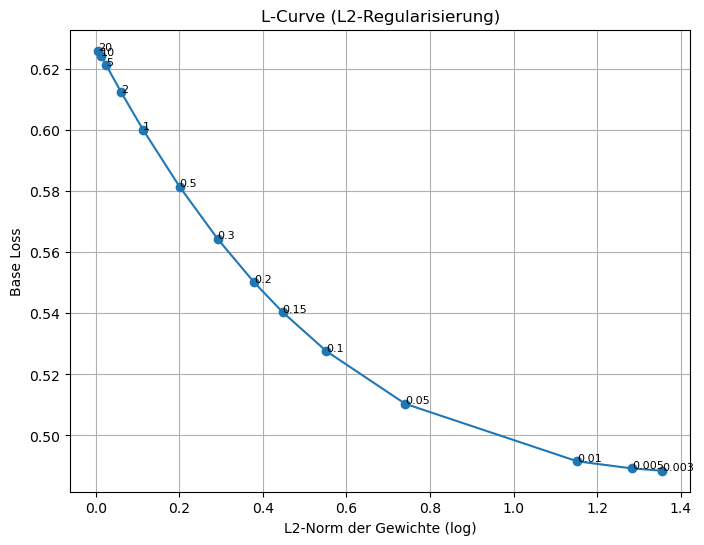

In [57]:
alphas = [0.003, 0.005, 0.01, 0.05, 0.1, 0.15, 0.2, 0.3, 0.5, 1, 2, 5, 10, 20]      
l2_norms = []
base_losses = []

for alpha in alphas:
    model_total_losses = []
    model_l_losses = []
    model_base_losses = []
    if alpha < 2:
        lrs = np.logspace(0, -3, num = 20)
    else:
        lrs = np.logspace(-1, -6, num = 30)
    for lr in lrs:
        try:
            model = LR_complete(input_dimensions=X.shape[1])
            model.fit(X, y, regularization='l2', alpha=alpha, learning_rate=lr)

            # Prüfen auf NaN oder zu hohe Werte
            if np.isnan(model.final_total_loss) or model.final_total_loss > 1e6:
                raise ValueError("Unplausibler Verlust")

            model_total_losses.append(model.final_total_loss)
            model_l_losses.append(model.l2_norm)
            model_base_losses.append(model.final_base_loss)

        except Exception as e:
            print(f"Fehler bei alpha={alpha}, lr={lr}: {e}")
            continue  # nächsten Lernratenwert versuchen

    # Falls keine gültige Kombination gefunden wurde, überspringen
    if not model_total_losses:
        print(f"Keine gültigen Ergebnisse für alpha={alpha}")
        continue

    i = np.argmin(model_total_losses)

    print("Alpha = %.3f -> Beste Lernrate = %.5f" % (alpha, lrs[i]))
    
    l2_norms.append(model_l_losses[i])
    base_losses.append(model_base_losses[i])

plt.figure(figsize=(8, 6))
plt.plot(l2_norms, base_losses, marker='o')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("L2-Norm der Gewichte (log)")
plt.ylabel("Base Loss")
plt.title("L-Curve (L2-Regularisierung)")
plt.grid(True)
for i, txt in enumerate(alphas):
    plt.annotate(f"{txt}", (l2_norms[i], base_losses[i]), fontsize=8)
plt.show()

Choose **$\alpha = 5$** for L2-regularization.

Alpha = 0.001 -> Beste Lernrate = 0.33598
Alpha = 0.010 -> Beste Lernrate = 0.00886
Alpha = 0.025 -> Beste Lernrate = 0.00616
Alpha = 0.050 -> Beste Lernrate = 0.00428
Alpha = 0.075 -> Beste Lernrate = 0.00428
Alpha = 0.100 -> Beste Lernrate = 0.00428
Alpha = 0.300 -> Beste Lernrate = 0.00144
Alpha = 1.000 -> Beste Lernrate = 0.00144
Alpha = 10.000 -> Beste Lernrate = 0.00144


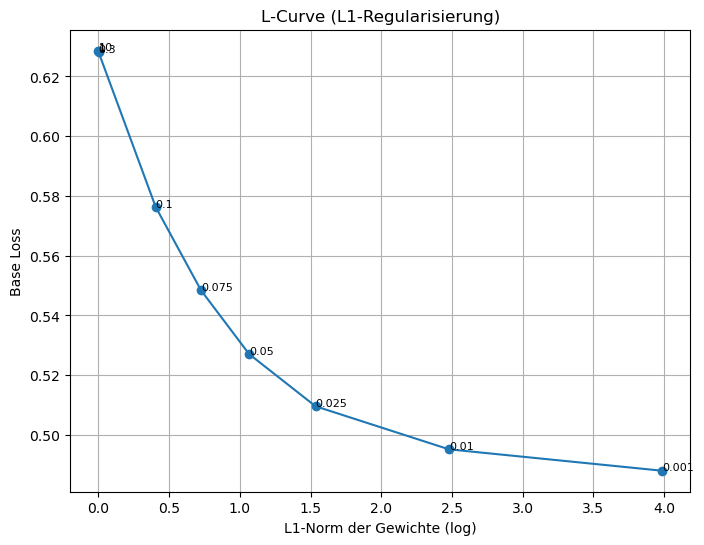

In [58]:
alphas = [0.001, 0.01, 0.025, 0.05, 0.075, 0.1, 0.3, 1, 10]      
l1_norms = []
base_losses = []

for alpha in alphas:
    model_total_losses = []
    model_l_losses = []
    model_base_losses = []
    if alpha <= 1:
        lrs = np.logspace(0, -3, num = 20)
    else:
        lrs = np.logspace(-2, -6, num = 20)
    for lr in lrs:
        try:
            model = LR_complete(input_dimensions=X.shape[1])
            model.fit(X, y, regularization='l1', alpha=alpha, learning_rate=lr)

            # Prüfen auf NaN oder zu hohe Werte
            if np.isnan(model.final_total_loss) or model.final_total_loss > 1e6:
                raise ValueError("Unplausibler Verlust")

            model_total_losses.append(model.final_total_loss)
            model_l_losses.append(model.l1_norm)
            model_base_losses.append(model.final_base_loss)

        except Exception as e:
            print(f"Fehler bei alpha={alpha}, lr={lr}: {e}")
            continue  # nächsten Lernratenwert versuchen

    # Falls keine gültige Kombination gefunden wurde, überspringen
    if not model_total_losses:
        print(f"Keine gültigen Ergebnisse für alpha={alpha}")
        continue

    i = np.argmin(model_total_losses)
    print("Alpha = %.3f -> Beste Lernrate = %.5f" % (alpha, lrs[i]))

    
    l1_norms.append(model_l_losses[i])
    base_losses.append(model_base_losses[i])

plt.figure(figsize=(8, 6))
plt.plot(l1_norms, base_losses, marker='o')
plt.xscale('linear')
plt.yscale('linear')
plt.xlabel("L1-Norm der Gewichte (log)")
plt.ylabel("Base Loss")
plt.title("L-Curve (L1-Regularisierung)")
plt.grid(True)
for i, txt in enumerate(alphas):
    plt.annotate(f"{txt}", (l1_norms[i], base_losses[i]), fontsize=8)
plt.show()

Choose $\alpha = $ for L1-Regularization.

## **Compare models with different regularizations by using crossvalidation**

In [59]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score


kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)


all_aucs = []
all_accuracies = []

for regularization, learning_rate, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    accuracies = []

    roc_aucs = []

    # Cross-Validation Schleife
    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]
        X_val_fold = X.iloc[val_index]
        y_val_fold = y.iloc[val_index]

        model = LR_complete(input_dimensions = X_train_fold.shape[1])

        model.fit(X_train_fold, y_train_fold, regularization = regularization, alpha = alpha, learning_rate = learning_rate)

        y_pred_fold = model.pred(X_val_fold)

        y_pred_fold = y_pred_fold.detach().numpy()

        y_pred_fold_classes = (y_pred_fold >= 0.5).astype(int)

        acc = accuracy_score(y_val_fold, y_pred_fold_classes)
        accuracies.append(acc)

        auc = roc_auc_score(y_val_fold, y_pred_fold)
        roc_aucs.append(auc)

        print(f"Fold {fold + 1}: Accuracy = {acc:.4f}, ROC AUC = {auc:.4f}")

    all_accuracies.append(accuracies)
    all_aucs.append(roc_aucs)
    

Fold 1: Accuracy = 0.6333, ROC AUC = 0.7000
Fold 2: Accuracy = 0.6333, ROC AUC = 0.6650
Fold 3: Accuracy = 0.7333, ROC AUC = 0.7200
Fold 4: Accuracy = 0.7667, ROC AUC = 0.8150
Fold 5: Accuracy = 0.7333, ROC AUC = 0.7750
Fold 6: Accuracy = 0.6667, ROC AUC = 0.6750
Fold 7: Accuracy = 0.9667, ROC AUC = 0.9259
Fold 8: Accuracy = 0.7667, ROC AUC = 0.8095
Fold 9: Accuracy = 0.7667, ROC AUC = 0.8889
Fold 10: Accuracy = 0.8276, ROC AUC = 0.7500
Fold 1: Accuracy = 0.6333, ROC AUC = 0.7150
Fold 2: Accuracy = 0.7333, ROC AUC = 0.6350
Fold 3: Accuracy = 0.6000, ROC AUC = 0.7250
Fold 4: Accuracy = 0.8000, ROC AUC = 0.8850
Fold 5: Accuracy = 0.8333, ROC AUC = 0.7600
Fold 6: Accuracy = 0.7000, ROC AUC = 0.6600
Fold 7: Accuracy = 0.9667, ROC AUC = 0.9365
Fold 8: Accuracy = 0.8000, ROC AUC = 0.8519
Fold 9: Accuracy = 0.7000, ROC AUC = 0.8519
Fold 10: Accuracy = 0.8276, ROC AUC = 0.8278
Fold 1: Accuracy = 0.6667, ROC AUC = 0.7200
Fold 2: Accuracy = 0.7000, ROC AUC = 0.6900
Fold 3: Accuracy = 0.6000, ROC

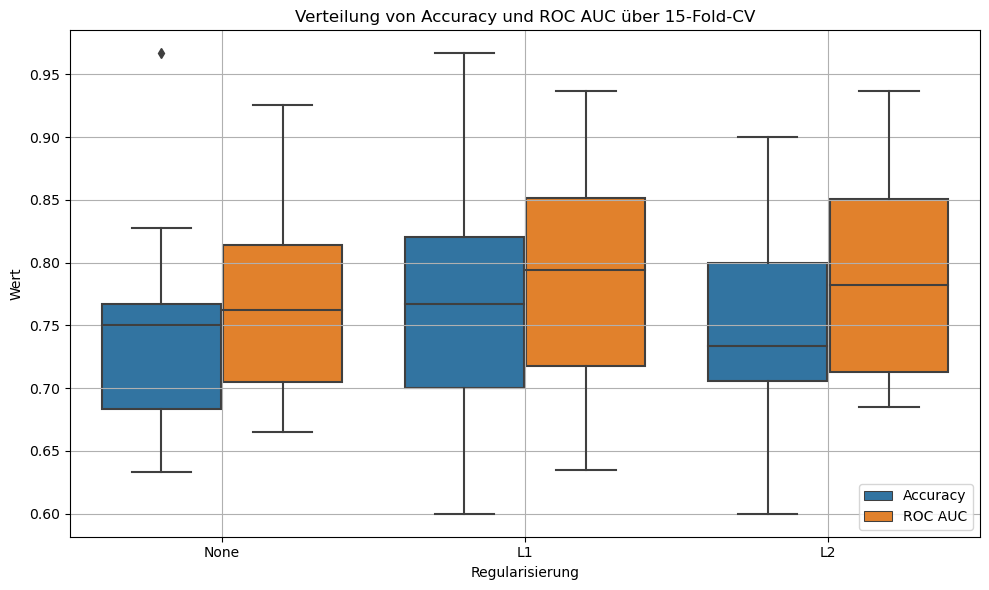

   Regularisierung    Metrik      Wert
0             None  Accuracy  0.633333
1             None  Accuracy  0.633333
2             None  Accuracy  0.733333
3             None  Accuracy  0.766667
4             None  Accuracy  0.733333
5             None  Accuracy  0.666667
6             None  Accuracy  0.966667
7             None  Accuracy  0.766667
8             None  Accuracy  0.766667
9             None  Accuracy  0.827586
10              L1  Accuracy  0.633333
11              L1  Accuracy  0.733333
12              L1  Accuracy  0.600000
13              L1  Accuracy  0.800000
14              L1  Accuracy  0.833333
15              L1  Accuracy  0.700000
16              L1  Accuracy  0.966667
17              L1  Accuracy  0.800000
18              L1  Accuracy  0.700000
19              L1  Accuracy  0.827586
20              L2  Accuracy  0.666667
21              L2  Accuracy  0.700000
22              L2  Accuracy  0.600000
23              L2  Accuracy  0.800000
24              L2  Accur

In [60]:
import seaborn as sns

# Labels für Regularisierungsarten
methods = ['None', 'L1', 'L2']

# Accuracy-Daten vorbereiten
acc_data = []
for i, method in enumerate(methods):
    for acc in all_accuracies[i]:
        acc_data.append({'Regularisierung': method, 'Metrik': 'Accuracy', 'Wert': acc})

# AUC-Daten vorbereiten
auc_data = []
for i, method in enumerate(methods):
    for auc in all_aucs[i]:
        auc_data.append({'Regularisierung': method, 'Metrik': 'ROC AUC', 'Wert': auc})

# Kombinieren
plot_data = pd.DataFrame(acc_data + auc_data)

# Plot
plt.figure(figsize=(10, 6))
sns.boxplot(data=plot_data, x='Regularisierung', y='Wert', hue='Metrik')
plt.title('Verteilung von Accuracy und ROC AUC über 15-Fold-CV')
plt.grid(True)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()
print(plot_data)

We need to save the modell evaluation parameters in a DataFrame to use it, to compare all models later on.

In [ ]:
import pandas as pd

models = ['None', 'L1', 'L2']
data = []

for i, model in enumerate(models):
    for fold in range(len(all_accuracies[i])):
        data.append({
            'Modell': model,
            'Fold': fold + 1,           # Fold von 1 bis 10
            'ROC AUC': all_aucs[i][fold],
            'Accuracy': all_accuracies[i][fold]
        })

model_evaluation = pd.DataFrame(data)

   Modell  Fold   ROC AUC  Accuracy
0    None     1  0.700000  0.633333
1    None     2  0.665000  0.633333
2    None     3  0.720000  0.733333
3    None     4  0.815000  0.766667
4    None     5  0.775000  0.733333
5    None     6  0.675000  0.666667
6    None     7  0.925926  0.966667
7    None     8  0.809524  0.766667
8    None     9  0.888889  0.766667
9    None    10  0.750000  0.827586
10     L1     1  0.715000  0.633333
11     L1     2  0.635000  0.733333
12     L1     3  0.725000  0.600000
13     L1     4  0.885000  0.800000
14     L1     5  0.760000  0.833333
15     L1     6  0.660000  0.700000
16     L1     7  0.936508  0.966667
17     L1     8  0.851852  0.800000
18     L1     9  0.851852  0.700000
19     L1    10  0.827778  0.827586
20     L2     1  0.720000  0.666667
21     L2     2  0.690000  0.700000
22     L2     3  0.710000  0.600000
23     L2     4  0.830000  0.800000
24     L2     5  0.770000  0.800000
25     L2     6  0.685000  0.733333
26     L2     7  0.936508  0

Now we want to comapre the parameter values. To do so, we fit the model for all the data, without splitting it up. We plot the estimated coefficients and show for effects of regularization.

In [61]:
model_weights = {}
regularizations = [None, 'l1', 'l2']
learning_rates = [0.5, 0.006, 1]
alphas = [None, 0.025, 0.05]

for reg, lr, alpha in zip(regularizations, learning_rates, alphas):
    model = LR_complete(input_dimensions=X.shape[1])
    model.fit(X, y, regularization=reg, alpha=alpha, learning_rate=lr)
    
    weights = model.final_weights.detach().numpy().flatten()
    model_weights[reg if reg else 'None'] = weights


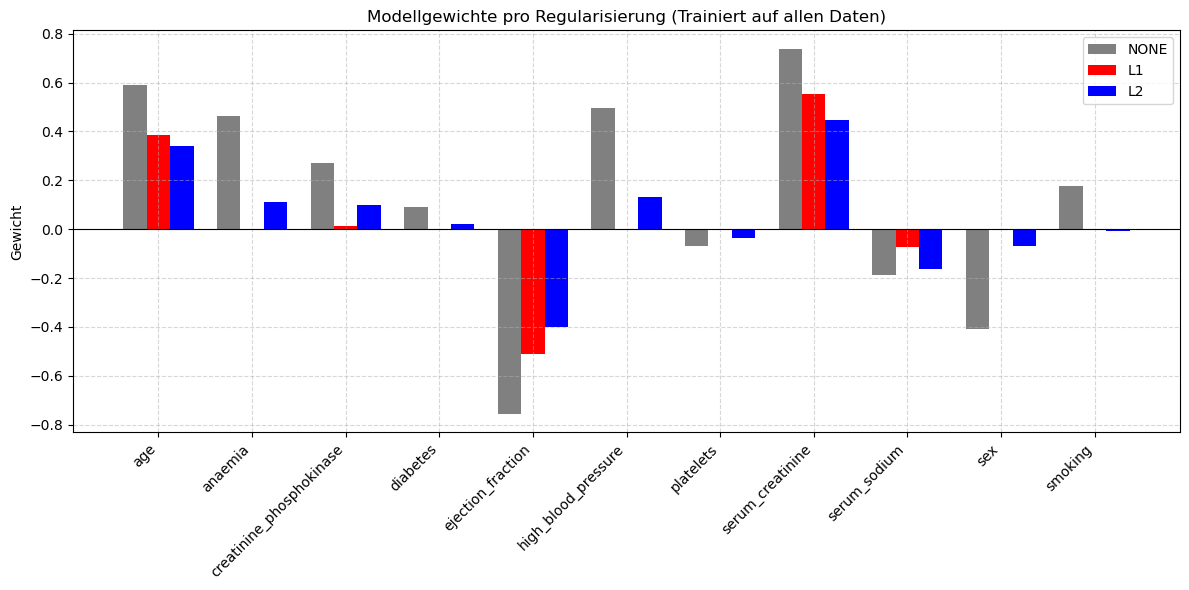

In [62]:
feature_names = X.columns
x = np.arange(len(feature_names))

plt.figure(figsize=(12, 6))

width = 0.25
offsets = {'None': -width, 'l1': 0, 'l2': width}
colors = {'None': 'gray', 'l1': 'red', 'l2': 'blue'}

for reg_type in ['None', 'l1', 'l2']:
    weights = model_weights[reg_type]
    plt.bar(x + offsets[reg_type], weights, width=width, label=reg_type.upper(), color=colors[reg_type])

plt.xticks(x, feature_names, rotation=45, ha='right')
plt.ylabel('Gewicht')
plt.title('Modellgewichte pro Regularisierung (Trainiert auf allen Daten)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

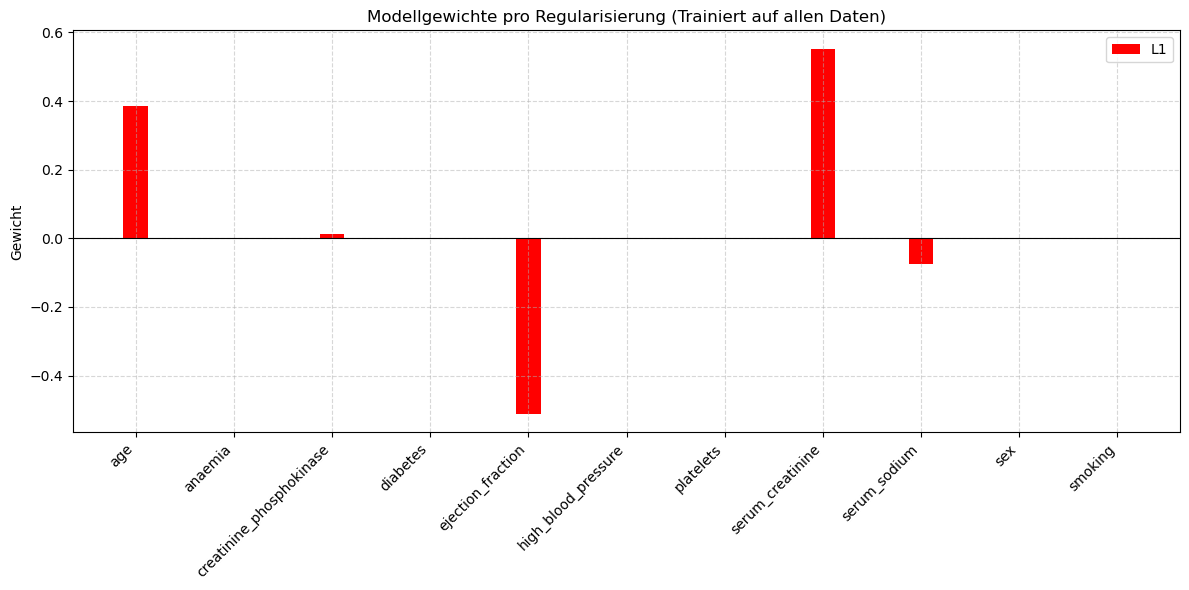

In [63]:
feature_names = X.columns
x = np.arange(len(feature_names))

plt.figure(figsize=(12, 6))

width = 0.25
offsets = { 'l1': 0}
colors = {'l1': 'red'}

for reg_type in [ 'l1']:
    weights = model_weights[reg_type]
    plt.bar(x + offsets[reg_type], weights, width=width, label=reg_type.upper(), color=colors[reg_type])

plt.xticks(x, feature_names, rotation=45, ha='right')
plt.ylabel('Gewicht')
plt.title('Modellgewichte pro Regularisierung (Trainiert auf allen Daten)')
plt.axhline(0, color='black', linewidth=0.8)
plt.legend()
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

One can see, that the performances do not differ too much. So, in particular without regularization we get as good results as without. Now, we want to have a look, if the weights are always predicted in the same way. If so, we would have a more stable model.

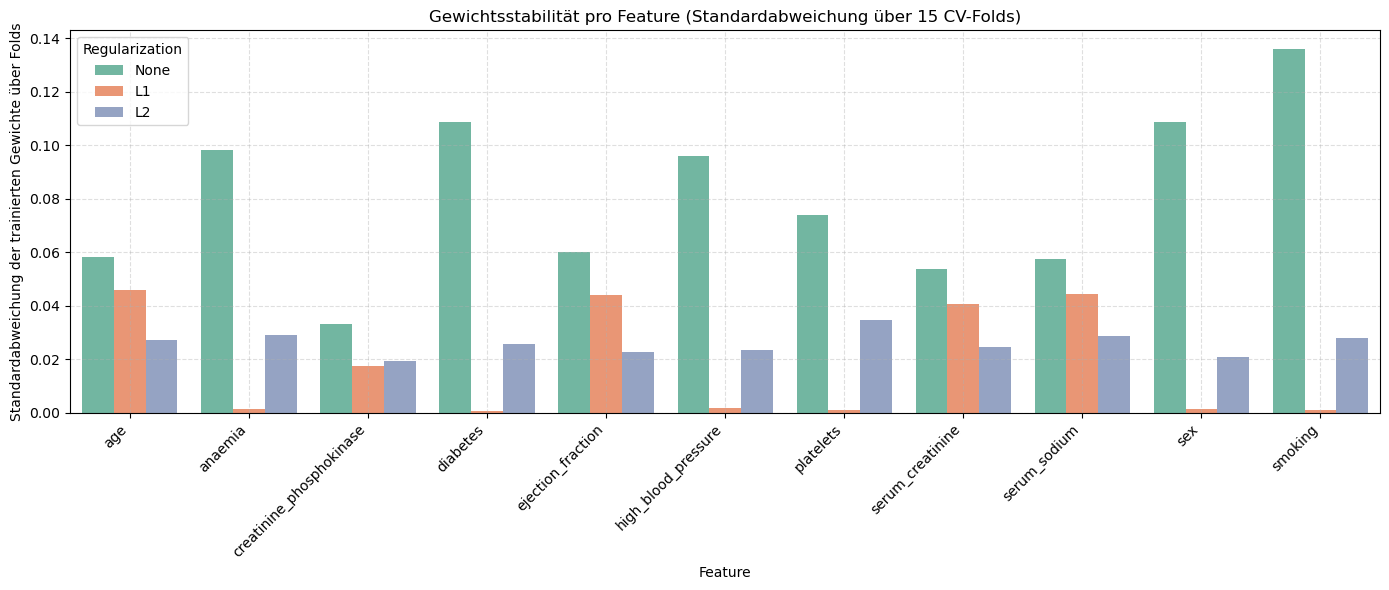

In [64]:
from collections import defaultdict

# Dict: Speichert die Gewichtswerte für jeden Regularisierungstyp
weight_tracking = defaultdict(list)

for reg, lr, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    reg_name = 'None' if reg is None else reg.upper()
    
    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]

        model = LR_complete(input_dimensions=X.shape[1])
        model.fit(X_train_fold, y_train_fold,
                  regularization=reg, alpha=alpha, learning_rate=lr)

        weights = model.final_weights.detach().numpy().flatten()
        weight_tracking[reg_name].append(weights)

weight_stability = {}

for reg_type, weights_list in weight_tracking.items():
    weights_array = np.vstack(weights_list)  
    std_per_feature = np.std(weights_array, axis=0)
    weight_stability[reg_type] = std_per_feature

# DataFrame zur Visualisierung vorbereiten
plot_df = pd.DataFrame({
    'Feature': np.tile(X.columns, 3),
    'Std': np.concatenate([
        weight_stability['None'],
        weight_stability['L1'],
        weight_stability['L2']
    ]),
    'Regularization': ['None'] * len(X.columns) +
                      ['L1'] * len(X.columns) +
                      ['L2'] * len(X.columns)
})

plt.figure(figsize=(14, 6))
sns.barplot(data=plot_df, x='Feature', y='Std', hue='Regularization', palette='Set2')
plt.title("Gewichtsstabilität pro Feature (Standardabweichung über 15 CV-Folds)")
plt.xticks(rotation=45, ha='right')
plt.ylabel("Standardabweichung der trainierten Gewichte über Folds")
plt.xlabel("Feature")
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()


## **Running Time Analysis**

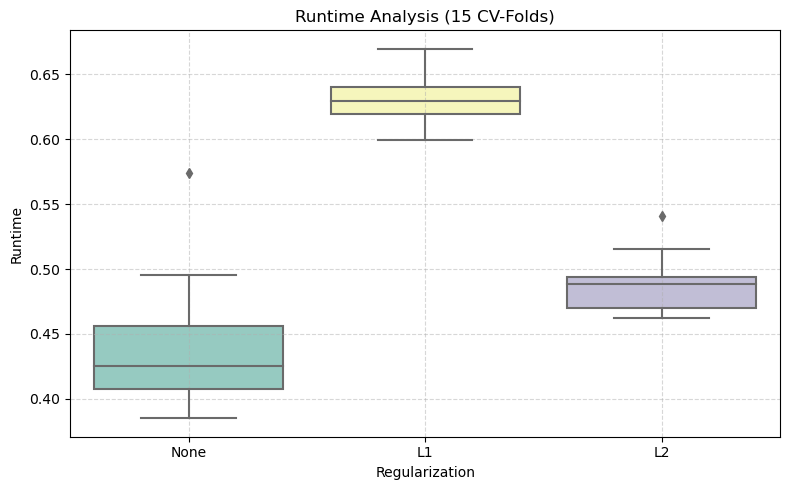

In [69]:
import time

all_running_times = []
reg_names = []

for reg, lr, alpha in zip([None, 'l1', 'l2'], [0.5, 0.006, 1], [None, 0.025, 0.05]):
    running_times = []
    reg_name = 'None' if reg is None else reg.upper()

    for fold, (train_index, val_index) in enumerate(kf.split(X,y)):
        X_train_fold = X.iloc[train_index]
        y_train_fold = y.iloc[train_index]

        model = LR_complete(input_dimensions=X.shape[1])
        
        start_time = time.time()
        model.fit(X_train_fold, y_train_fold,
                  regularization=reg, alpha=alpha, learning_rate=lr)
        end_time = time.time()

        runtime = end_time - start_time
        running_times.append(runtime)

    all_running_times.extend(running_times)
    reg_names.extend([reg_name] * len(running_times))


runtime_df = pd.DataFrame({
    'Regularization': reg_names,
    'Runtime': all_running_times
})


# Use information in model_evaluation
model_evaluation['Running_Time'] = runtime_df['Runtime'].values

plt.figure(figsize=(8, 5))
sns.boxplot(data=runtime_df, x='Regularization', y='Runtime', palette='Set3')
plt.title("Runtime Analysis (15 CV-Folds)")
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

In [72]:
model_evaluation

,Modell,Fold,ROC AUC,Accuracy,Running_Time
0,None,1,0.700000,0.633333,0.574275
1,None,2,0.665000,0.633333,0.495431
2,None,3,0.720000,0.733333,0.402775
3,None,4,0.815000,0.766667,0.434946
4,None,5,0.775000,0.733333,0.411752
5,None,6,0.675000,0.666667,0.406331
6,None,7,0.925926,0.966667,0.458301
7,None,8,0.809524,0.766667,0.415788
8,None,9,0.888889,0.766667,0.450194
9,None,10,0.750000,0.827586,0.385050


In [71]:
model_evaluation.to_pickle('model_evaluation/logistic_regression.pkl')